In [1]:
import numpy as np
import scipy as sp
import os
import sys
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
lgcg_path = os.path.abspath(os.path.join('../lazified_pdap'))
if lgcg_path not in sys.path:
    sys.path.append(lgcg_path)
from lib.measure import Measure
from lazified_pdap import LazifiedPDAP

# Heat Equation

## Generate Data and Define Functions

In [2]:
Omega = np.array([[0,1], [0,1]])
alpha = 1e-1
observation_resolution = 4
std_factor = 0.1
true_sources = np.array([[0.28, 0.71], [0.51,0.27], [0.71,0.53]])
true_weights = np.array([1,-0.7, 0.8])

In [3]:
observations = (np.array(np.meshgrid(
                    *(
                        np.linspace(bound[0], bound[1], observation_resolution+2)
                        for bound in Omega
                    ))
            ).reshape(len(Omega), -1).T)
observations = np.array([obs for obs in observations if all(obs!=0) and all(obs!=1)])

In [4]:
def kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    columns = []
    outer_factor = np.sqrt(std_factor*np.pi)**Omega.shape[0]
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated = np.exp(norms) # (len(x),)
        columns.append(exponentiated)
    result = np.transpose(np.array(columns), axes=(1,0))/outer_factor # shape=(len(x), len(observations))
    return result

In [5]:
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(kappa)

In [6]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(kappa) - target) ** 2

In [7]:
def grad_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    gradients = []
    outer_factor = std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]/2
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated = np.exp(norms) # (len(x),)
        gradient = diff * exponentiated.reshape(-1,1) # shape=(len(x),Omega.shape[0])
        gradients.append(gradient)
    result = np.transpose(np.array(gradients), axes=(1,0,2))/outer_factor # The Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0])
    return result

In [8]:
def hess_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    hessians = []
    outer_factors = [-std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]/2,std_factor**2*np.sqrt(std_factor*np.pi)**Omega.shape[0]/4]
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated_normed_1 = np.exp(norms)/outer_factors[0] # (len(x),)
        exponentiated_normed_2 = np.exp(norms)/outer_factors[1] # (len(x),)
        first_part = np.repeat(np.eye(Omega.shape[0])[np.newaxis,:],len(x),axis=0)*exponentiated_normed_1.reshape(-1,1,1) # shape=(len(x),Omega.shape[0],Omega.shape[0])
        second_part = np.einsum('ij,ik->ijk', diff, diff)*exponentiated_normed_2.reshape(-1,1,1) # shape=(len(x),Omega.shape[0],Omega.shape[0])
        hessians.append(first_part+second_part)
    result = np.transpose(np.array(hessians), axes=(1,0,2,3)) # The derivative of the Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0], Omega.shape[0])
    return result

In [9]:
def p_raw(u):
    Ku = u.duality_pairing(kappa)
    inner = Ku-target
    return lambda x: -kappa(x) @ inner

p = lambda u: p_raw(u)

In [10]:
def grad_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1)*np.tensordot(grad_kappa(x), inner, axes=([1,0]))

grad_P = lambda u: grad_P_raw(u)

In [11]:
def hess_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1,1)*np.tensordot(hess_kappa(x),inner,axes=([1,0]))

hess_P = lambda u: hess_P_raw(u)

In [12]:
def grad_j(positions, coefs):
    K_matrix = kappa(positions)
    grad_F = (K_matrix.T@coefs).flatten() - target
    nabla_x = coefs.reshape(-1,1)*np.tensordot(grad_kappa(positions), grad_F, axes=([1,0]))
    nabla_u = np.dot(K_matrix, grad_F) + alpha * np.sign(coefs)
    return np.append(nabla_x.flatten(), nabla_u, axis=0).flatten()

In [13]:
def hess_j(positions, coefs):
    kappa_values = kappa(positions)
    grad_kappa_values = grad_kappa(positions)
    hess_kappa_values = hess_kappa(positions)
    matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
    hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
    step = Omega.shape[0]
    coefs_delay = step*len(positions)
    inner = (kappa_values.T@coefs).flatten() - target
    for i in range(len(positions)):
        # nabla_{x_i,x_j}
        for j in range(len(positions)):
            if j<i:
                continue
            block = coefs[i]*coefs[j]*np.matmul(grad_kappa_values[i].T, grad_kappa_values[j])
            if i==j:
                block += coefs[i]*np.tensordot(hess_kappa_values[i],inner,axes=([0,0]))
            hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
            hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
        # nabla_{x_i,u_j}
        for j in range(len(coefs)):
            block = coefs[i]*np.matmul(grad_kappa_values[i].T, kappa_values[j])
            if i == j:
                block += np.matmul(grad_kappa_values[i].T, inner)
            hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
            hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
    for i in range(len(coefs)):
        # nabla_{u_i,u_j}
        for j in range(len(coefs)):
            if j<i:
                continue
            block = np.dot(kappa_values[i], kappa_values[j])
            hesse_matrix[coefs_delay+i,coefs_delay+j] = block
            hesse_matrix[coefs_delay+j,coefs_delay+i] = block
    return hesse_matrix

In [14]:
a = np.arange(0,1,0.01)
if Omega.shape[0] == 1:
    vals = np.linalg.norm(kappa(a.reshape(1,-1).T), axis=1)
    norm_K_star = max(vals)
elif Omega.shape[0] == 2:
    x, y = np.meshgrid(a,a)
    points = np.array(list(zip(x.flatten(), y.flatten())))
    vals = np.linalg.norm(kappa(points), axis=1)
    norm_K_star = max(vals) # ||k([0.5,0.5])||
elif Omega.shape[0] == 3:
    x, y, z = np.meshgrid(a,a,a)
    points = np.array(list(zip(x.flatten(), y.flatten(), z.flatten())))
    vals = np.linalg.norm(kappa(points), axis=1)
    norm_K_star = max(vals)
else:
    norm_K_star = 10
norm_K_star

6.264527262470839

In [15]:
a = np.arange(0,1,0.1)
if Omega.shape[0] == 1:
    vals = np.linalg.norm(grad_kappa(a.reshape(1,-1).T), axis=(1,2))
    norm_K_star_L = max(vals)
elif Omega.shape[0] == 2:
    B, D = np.meshgrid(a,a)
    points = np.array(list(zip(B.flatten(), D.flatten())))
    vals = np.linalg.norm(grad_kappa(points), axis=(1,2))
    norm_K_star_L = max(vals)
elif Omega.shape[0] == 3:
    x, y, z = np.meshgrid(a,a,a)
    points = np.array(list(zip(x.flatten(), y.flatten(), z.flatten())))
    vals = np.linalg.norm(grad_kappa(points), axis=(1,2))
    norm_K_star_L = max(vals)
else:
    norm_K_star_L = 50
norm_K_star_L

27.126794337315015

In [16]:
gamma = 0.5
theta = 1e-1
sigma = 2e-3
m = 1e-3
bar_m = 1e-1
L = 1
L_H = max(np.abs(true_weights))
R = 1e-2
L_H

1.0

## Experiments

In [17]:
exp = LazifiedPDAP(target=target, 
           kappa=kappa, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_K_star=norm_K_star,
           norm_K_star_L=norm_K_star_L,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           gamma=gamma,
           theta=theta,
           sigma=sigma,
           m=m,
           bar_m=bar_m,
           L=L,
           L_H=L_H,
           R=R
           )

In [18]:
exp.M

259.0174619826847

### PDAP

In [18]:
u, P_values, times, supports, objective_values = exp.pdap(tol=1e-15)

DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:1: Phi:3.290E+03, support: [[0.44043758 0.69141258]], coefs: [1.05279812], x: [0.42427898 0.23939056]
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:2: Phi:1.586E+03, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141258]], coefs: [-0.46886794  1.23385151], x: [0.83741191 0.49779621]
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:3: Phi:1.290E+03, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141258]
 [0.83741191 0.49779621]], coefs: [-0.53679209  1.13760922  0.3139453 ], x: [0.14118912 0.63968789]
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:4: Phi:3.331E+02, support: [[0.14118912 0.63968789

In [19]:
best = objective_values[-1]

In [20]:
np.array(times[:150])

array([2.38418579e-07, 4.53706264e-01, 9.27096128e-01, 1.40432858e+00,
       1.88521719e+00, 2.51944041e+00, 3.05500627e+00, 3.56358933e+00,
       4.08990955e+00, 4.61842442e+00, 5.21633482e+00, 5.84030795e+00,
       6.34057927e+00, 6.80048609e+00, 7.29537439e+00, 7.80027580e+00,
       8.29169369e+00, 8.77746987e+00, 9.26843262e+00, 9.75599408e+00,
       1.03222053e+01, 1.09156394e+01, 1.14361475e+01, 1.18833761e+01,
       1.23413351e+01, 1.28029788e+01, 1.32692134e+01, 1.37113070e+01,
       1.42245631e+01, 1.47049112e+01, 1.51560345e+01, 1.56311834e+01,
       1.60974216e+01, 1.65677507e+01, 1.70256970e+01, 1.74750354e+01,
       1.79271338e+01, 1.83822894e+01, 1.88386552e+01, 1.94864688e+01,
       2.00261183e+01, 2.05084424e+01, 2.09907329e+01, 2.16012576e+01,
       2.21181920e+01, 2.27581513e+01, 2.33377709e+01, 2.38085351e+01,
       2.42744792e+01, 2.48410735e+01, 2.53730607e+01, 2.59617853e+01,
       2.65504203e+01, 2.70699439e+01, 2.76257725e+01, 2.81376014e+01,
      

In [21]:
np.array(supports[:150])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 7, 8, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9,
       8, 9, 8, 8, 9, 8, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 7, 8, 8, 8, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 9,
       9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 9, 8, 9, 9])

In [22]:
objective_values[:150]-best

array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903637e+00,
       2.29592885e-01, 1.29111896e-01, 6.02585416e-02, 5.81289511e-02,
       5.43698663e-02, 4.28609944e-02, 2.43456506e-02, 2.24655450e-02,
       2.19692477e-02, 1.97512431e-02, 1.45352926e-02, 1.17524225e-02,
       8.37236219e-03, 8.03803924e-03, 7.27480805e-03, 5.49766940e-03,
       4.74499601e-03, 4.33283626e-03, 3.06984423e-03, 3.03428444e-03,
       2.57014217e-03, 2.25412097e-03, 2.23311015e-03, 1.77761534e-03,
       1.74648392e-03, 1.02712747e-03, 1.00858178e-03, 7.05155587e-04,
       4.57693388e-04, 3.73211977e-04, 3.33190169e-04, 3.26992818e-04,
       3.19892471e-04, 2.76244554e-04, 2.23205519e-04, 2.02456251e-04,
       1.54179999e-04, 1.15910020e-04, 8.64004635e-05, 6.07039715e-05,
       5.67239423e-05, 4.57612933e-05, 4.45947156e-05, 4.10278346e-05,
       3.04747041e-05, 1.81648547e-05, 1.30623802e-05, 1.09291962e-05,
       1.01616338e-05, 9.32082142e-06, 8.04376060e-06, 5.27265804e-06,
      

In [23]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322718 0.71433127]
 [0.28322723 0.7143313 ]
 [0.28322724 0.7143313 ]
 [0.28322729 0.71433134]
 [0.28322732 0.7143313 ]
 [0.28322732 0.71433129]
 [0.49565835 0.23548624]
 [0.49565837 0.23548621]
 [0.49565837 0.2354862 ]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565838 0.23548617]
 [0.49565839 0.2354862 ]
 [0.49565839 0.2354862 ]
 [0.49565839 0.2354862 ]
 [0.49565839 0.2354862 ]
 [0.49565839 0.2354862 ]
 [0.73058821 0.54790141]
 [0.73058831 0.54790136]
 [0.73058832 0.54790137]
 [0.73058841 0.54790129]] and coefficients [ 1.44874328e-01  5.67996613e-02  5.88778150e-02  6.38521848e-01
  9.27714938e-02  3.84628086e-03 -2.48979947e-01 -3.22052288e-03
 -7.15067021e-03 -1.48326203e-02 -2.35247682e-02 -2.41131140e-01
 -4.51982584e-03 -1.42658317e-05 -3.26065228e-02 -3.76923426e-04
 -4.12234923e-02  1.46561027e-01  1.76678895e-01  9.78807852e-02
  2.91011554e-01]
[2.53214116e-13]
3.1893931939919185e-13


### Newton

In [29]:
u, times, supports, inner_loop, inner_lazy, inner_total, outer_lazy, outer_total, objective_values = exp.newton(tol=1e-12, damped=False, lgcg_frequency=5)

INFO:root:1: choice: 0, lazy: True, support: [], epsilon: 0.05000000000000001, objective: 2.590E+01
INFO:root:True, True, True, True, True
INFO:root:2, 1: lazy: True, support: [[0.44444444 0.68686869]], coefs: [0.24313342], epsilon: 0.05000000000000001, objective: 1.770E+01
INFO:root:True, True, True, True, True
INFO:root:2, 2: lazy: N/A, support: [[0.39580212 0.77166564]], coefs: [1.07721868], epsilon: 0.05000000000000001, objective: 5.294E+00
INFO:root:True, True, True, True, True
INFO:root:2, 3: lazy: N/A, support: [[0.41739199 0.75205174]], coefs: [1.1253606], epsilon: 0.05000000000000001, objective: 5.130E+00
INFO:root:True, True, False, True, True
DEBUG:root:SSN in 1 dimensions converged in 1 iterations to tolerance 2.500E-04
INFO:root:2: choice: 2, lazy: True, support: [[0.41635812 0.75329279]], epsilon: 0.05000000000000001, objective: 5.129E+00
INFO:root:True, True, True, True, True
INFO:root:3, 1: lazy: True, support: [[0.41414141 0.2020202 ]
 [0.41635812 0.75329279]], coefs: 

In [30]:
np.array(times)

array([7.15255737e-07, 9.65309143e-03, 2.40828991e-02, 3.09450626e-02,
       3.70595455e-02, 5.00686169e-02, 6.35924339e-02, 6.95402622e-02,
       7.57000446e-02, 8.20293427e-02, 9.56485271e-02, 1.12404585e-01,
       1.39577150e-01, 1.66254759e-01, 1.78715706e-01, 1.84191942e-01,
       7.08003044e-01, 1.18844914e+00, 1.75794649e+00, 1.78363061e+00,
       2.33380532e+00, 2.80413079e+00, 2.81504703e+00, 2.82054257e+00,
       3.29183769e+00, 3.46994400e+00, 3.99149084e+00])

In [31]:
np.array(supports)

array([0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 4, 5, 6, 6, 5, 6, 7, 6, 6, 7,
       4, 4, 3, 3, 3])

In [32]:
intervals = []
current_inner = False
for ind, i in enumerate(inner_loop):
    if i:
        if not current_inner:
            start = ind-0.5
            current_inner = True
    else:
        if current_inner:
            end = ind-0.5
            intervals.append((start,end))
            current_inner = False
np.array(intervals)

array([[ 1.5,  4.5],
       [ 5.5, 10.5],
       [13.5, 15.5],
       [21.5, 23.5],
       [24.5, 25.5]])

In [33]:
objective_values-best

array([ 2.56626430e+01,  2.56626430e+01,  1.74606299e+01,  5.05470051e+00,
        4.89062393e+00,  4.89010890e+00,  4.34012717e+00,  2.57954034e+00,
        2.46278057e+00,  2.45311211e+00,  2.45047563e+00,  1.37210241e+00,
        2.25970925e-01,  9.46248236e-02,  9.35884195e-02,  3.21552724e-02,
        2.53237027e-03,  2.37351925e-03,  2.28676260e-03,  1.03192011e-03,
        7.17546127e-05,  6.70808351e-05,  7.01373085e-03,  2.91460001e-05,
        2.90653696e-09,  2.90653757e-09, -3.46944695e-15])

In [34]:
print(inner_lazy)
print(inner_total)
print(outer_lazy)
print(outer_total)

13
13
6
13


In [35]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322727 0.71433132]
 [0.49565837 0.23548621]
 [0.73058833 0.54790134]] and coefficients [ 0.99569143 -0.6175807   0.71213226]
[1.80411242e-15]
1.4710455076283324e-15


In [36]:
hess = hess_j(u.support, u.coefficients)
np.linalg.eig(hess).eigenvalues

array([402.39077647, 272.29702466, 194.35314083,  68.45550373,
        48.27005118,   1.82700375,   7.42624618,  18.87504405,
        24.25981572])

### Newton Damped

In [46]:
u, times, supports, inner_loop, inner_lazy, inner_total, outer_lazy, outer_total, objective_values = exp.newton(tol=1e-12, damped=True, damping_root=1)

INFO:root:1: choice: 0, lazy: True, support: [], epsilon: 0.05000000000000001, objective: 2.590E+01
INFO:root:True, True, True, True, True
INFO:root:2, 1: lazy: True, support: [[0.44444444 0.68686869]], coefs: [0.24313342], epsilon: 0.05000000000000001, objective: 1.770E+01
INFO:root:True, True, True, True, True
INFO:root:2, 2: lazy: N/A, support: [[0.4413723  0.69222429]], coefs: [0.29581252], epsilon: 0.05000000000000001, objective: 1.619E+01
INFO:root:True, True, True, True, True
INFO:root:2, 3: lazy: N/A, support: [[0.43916149 0.69630035]], coefs: [0.34656846], epsilon: 0.05000000000000001, objective: 1.484E+01
INFO:root:True, True, True, True, True
INFO:root:2, 4: lazy: N/A, support: [[0.43738316 0.69973295]], coefs: [0.39565904], epsilon: 0.05000000000000001, objective: 1.362E+01
INFO:root:True, True, True, True, True
INFO:root:2, 5: lazy: True, support: [[0.43585617 0.70279706]], coefs: [0.44316896], epsilon: 0.05000000000000001, objective: 1.251E+01
INFO:root:True, True, True, 

In [47]:
np.array(times)

array([2.38418579e-07, 5.41281700e-03, 1.76355839e-02, 2.41577625e-02,
       3.03523540e-02, 3.67414951e-02, 4.75833416e-02, 5.32751083e-02,
       5.88154793e-02, 6.43019676e-02, 7.04236031e-02, 8.16042423e-02,
       8.74774456e-02, 9.34922695e-02, 9.99310017e-02, 1.05723381e-01,
       1.16555452e-01, 1.22693539e-01, 1.29113674e-01, 1.34928942e-01,
       1.40502930e-01, 1.51169777e-01, 1.57197714e-01, 1.63335800e-01,
       1.69991016e-01, 1.75750971e-01, 1.87001228e-01, 1.92858219e-01,
       1.99265242e-01, 2.05387831e-01, 2.11197376e-01, 2.24167824e-01,
       2.30447531e-01, 2.38195419e-01, 2.44183064e-01, 2.60089874e-01,
       2.72747278e-01, 2.79483318e-01, 2.85110712e-01, 2.89981604e-01,
       3.06290388e-01, 3.11129808e-01, 3.18518400e-01, 3.23826551e-01,
       3.29535246e-01, 3.42664242e-01, 3.49350452e-01, 3.55810642e-01,
       3.61460447e-01, 3.68844509e-01, 3.80911350e-01, 3.88760090e-01,
       3.94061089e-01, 4.00561333e-01, 4.05778885e-01, 4.16984320e-01,
      

In [48]:
np.array(supports)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3])

In [49]:
intervals = []
current_inner = False
for ind, i in enumerate(inner_loop):
    if i:
        if not current_inner:
            start = ind-0.5
            current_inner = True
    else:
        if current_inner:
            end = ind-0.5
            intervals.append((start,end))
            current_inner = False
np.array(intervals)

array([[ 1.5, 34.5],
       [35.5, 58.5],
       [61.5, 72.5]])

In [50]:
objective_values-best

array([ 2.56626430e+01,  2.56626430e+01,  1.74606299e+01,  1.59556125e+01,
        1.46006495e+01,  1.33776930e+01,  1.22753761e+01,  1.12845081e+01,
        1.03968791e+01,  9.60485702e+00,  8.90122927e+00,  8.27913165e+00,
        7.73201400e+00,  7.25362160e+00,  6.83798438e+00,  6.47940999e+00,
        6.17247893e+00,  5.91204096e+00,  5.69321212e+00,  5.51137241e+00,
        5.36216392e+00,  5.24148950e+00,  5.14551215e+00,  5.07065532e+00,
        5.01360428e+00,  4.97130886e+00,  4.94098782e+00,  4.92013480e+00,
        4.90652602e+00,  4.89822905e+00,  4.89361191e+00,  4.89135099e+00,
        4.89043497e+00,  4.89016059e+00,  4.89011206e+00,  3.13259275e+00,
        2.73039295e+00,  2.11989567e+00,  1.72060471e+00,  1.40539010e+00,
        1.14583499e+00,  9.29851543e-01,  7.49695470e-01,  5.99717572e-01,
        4.75444893e-01,  3.73142908e-01,  2.89592405e-01,  2.21969734e-01,
        1.67779467e-01,  1.24815174e-01,  9.11363231e-02,  6.50549364e-02,
        4.51275036e-02,  

In [51]:
print(inner_lazy)
print(inner_total)
print(outer_lazy)
print(outer_total)

17
17
2
6


In [52]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322727 0.71433132]
 [0.49565837 0.23548621]
 [0.73058833 0.54790134]] and coefficients [ 0.99569143 -0.6175807   0.71213226]
[5.17641485e-15]
7.216449660063518e-15


### LPDAP

In [24]:
u, Phi_ks, times, supports, objective_values = exp.lpdap(tol=1e-12)

/vol/cs-hu/hnatiuar@hu-berlin.de/Dokumente/lazified-generalized-conditional-gradient/lazified_pdap/lazified_pdap.py:448: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt(Phi_A)
INFO:root:1: Step: GCG, Lazy True, Phi_k: 9.886E+03, epsilon: 5.000E-02, support: [], coefs: []
INFO:root:==============================================
DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 5.000E-04
INFO:root:2: Step: GCG, Lazy True, Phi_k: 3.750E+02, epsilon: 5.000E-02, support: [[0.44444444 0.68686869]], coefs: [1.04692849]
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 5.000E-04
INFO:root:3: Step: GCG, Lazy True, Phi_k: 2.968E+03, epsilon: 5.000E-02, support: [[0.44444444 0.68686869]
 [0.53099843 0.8475285 ]], coefs: [0.81869591 0.30439042]
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 5.000E-04
INFO:root

In [25]:
np.array(times)

array([2.43186951e-03, 2.24134922e-02, 4.97074127e-02, 6.70232773e-02,
       8.06725025e-02, 9.26663876e-02, 1.03285313e-01, 1.18788719e-01,
       1.29771709e-01, 1.40192032e-01, 1.51462555e-01, 1.61025524e-01,
       1.82733774e-01, 1.94938183e-01, 2.08823204e-01, 2.27992058e-01,
       2.43440866e-01, 2.57202148e-01, 2.70761013e-01, 2.90256500e-01,
       3.14153433e-01, 3.36939573e-01, 3.58320475e-01, 3.82315397e-01,
       1.03577876e+00, 1.55664825e+00, 2.18835521e+00, 2.74982500e+00,
       3.31979847e+00, 3.82694697e+00, 4.30355740e+00, 4.31906104e+00,
       4.33344698e+00, 4.34934235e+00, 4.36340761e+00, 4.84839106e+00,
       4.86451626e+00, 4.88130379e+00, 4.89639401e+00, 4.91110802e+00,
       4.92838740e+00, 4.94672990e+00, 4.97623706e+00, 5.56060076e+00,
       6.23879528e+00, 6.25956225e+00, 6.28046155e+00, 6.29727793e+00,
       6.84683204e+00, 6.86595392e+00, 6.88634253e+00, 6.90331817e+00,
       6.92397332e+00, 6.94502521e+00, 6.96163368e+00, 7.47667742e+00,
      

In [26]:
np.array(supports)

array([ 0,  1,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  5,  6,  6,
        7,  7,  8,  8,  6,  7,  8,  9,  9,  9,  9,  9,  9,  9,  8,  8,  8,
        9,  9,  9,  9,  9,  9,  9,  9,  8,  9,  9,  8,  7,  8,  7,  7,  7,
        8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  8,  9,  9,  7,
        7,  8,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  8,  8,  8,  9,  9,  9,  8,  8,  8,  8,  9,
        9,  9,  9,  8,  8,  9,  9,  8,  7,  9,  9,  8,  8,  8,  9,  9,  9,
        9,  8,  8,  8,  9,  8,  9,  8,  8,  8,  8,  8,  9,  9, 10, 10, 12,
       12, 13, 14, 15, 18])

In [27]:
objective_values-best

array([2.56626430e+01, 5.68389440e+00, 5.46356874e+00, 2.51910533e+00,
       2.51910533e+00, 2.51910533e+00, 2.51910533e+00, 2.51910533e+00,
       2.51910533e+00, 2.51910533e+00, 2.51910533e+00, 2.51910533e+00,
       2.49298189e+00, 1.52469505e+00, 1.33945183e+00, 1.29802114e+00,
       8.46074183e-01, 5.13466532e-01, 4.14884802e-01, 3.91024809e-01,
       1.55155639e-01, 3.95412377e-02, 3.13866705e-02, 2.94766280e-02,
       2.82051874e-02, 2.82051874e-02, 2.82051874e-02, 2.82051874e-02,
       2.82051874e-02, 2.82051874e-02, 2.82051874e-02, 2.28594819e-02,
       1.96873290e-02, 1.86097853e-02, 1.70658195e-02, 1.07843188e-02,
       7.21661241e-03, 6.90838599e-03, 6.90838599e-03, 6.90838599e-03,
       6.90838599e-03, 6.90838599e-03, 4.05954674e-03, 4.03998724e-03,
       4.03998724e-03, 3.83862111e-03, 2.63344418e-03, 2.55210054e-03,
       2.05861557e-03, 1.62410716e-03, 1.06210969e-03, 1.02890516e-03,
       1.01916643e-03, 6.35489620e-04, 6.35489620e-04, 5.59247030e-04,
      

In [28]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322726 0.71433131]
 [0.28322733 0.71433139]
 [0.28322735 0.71433139]
 [0.28322735 0.71433139]
 [0.28322735 0.71433139]
 [0.28322736 0.71433146]
 [0.28322751 0.71433136]
 [0.49565833 0.23548618]
 [0.49565834 0.23548622]
 [0.49565834 0.23548623]
 [0.49565837 0.2354862 ]
 [0.49565839 0.23548618]
 [0.4956584  0.23548622]
 [0.73058821 0.54790137]
 [0.73058828 0.54790134]
 [0.73058829 0.54790135]
 [0.73058836 0.54790134]
 [0.73058838 0.54790127]] and coefficients [ 9.50098141e-01  1.20687852e-02  3.85470023e-03  5.51649827e-04
  2.02933084e-04  1.29278772e-06  2.89139285e-02 -9.59149305e-02
 -1.55270179e-01 -7.81935078e-02 -3.03045725e-05 -6.65604500e-02
 -2.21611328e-01  6.93048448e-02  1.18043012e-01  3.71202340e-05
  5.21152695e-01  3.59458738e-03]
[7.60502772e-15]
8.465450562766819e-15


## Plots

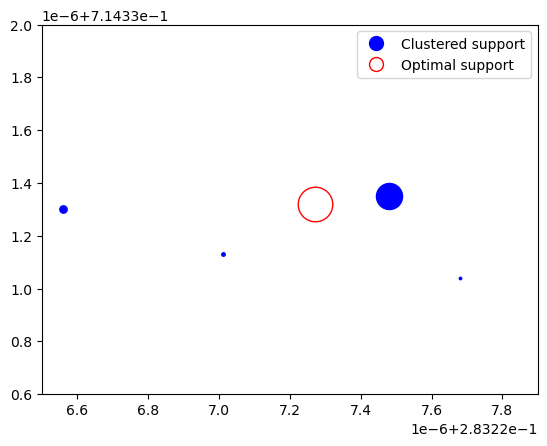

In [73]:
clustered_points = [[0.28322656, 0.7143313 ], [0.28322701, 0.71433113], [0.28322748, 0.71433135], [0.28322768, 0.71433104]]
clustered_weights = [0.21149885,  0.1,  0.75096038, 0.07]
true_point = [0.28322727, 0.71433132]
true_weight = 0.99569143
plt.plot(0,0,"o", c="b", markersize=10,label="Clustered support"); # Point for legend
plt.plot(0,0,"o", c="r", fillstyle="none", markersize=10,label="Optimal support"); # Point for legend
for (x,c) in zip(clustered_points, clustered_weights):
    plt.plot(x[0], x[1], "o", c="b", markersize=25*c);
plt.plot(true_point[0], true_point[1], "o", fillstyle="none", c="r", markersize=25*true_weight);
plt.ylim(7.143313e-1-7e-7, 7.143313e-1+7e-7)
plt.xlim(2.832272e-1-7e-7, 2.832272e-1+7e-7)
plt.legend(fontsize=10);

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f7e6eb964a0>


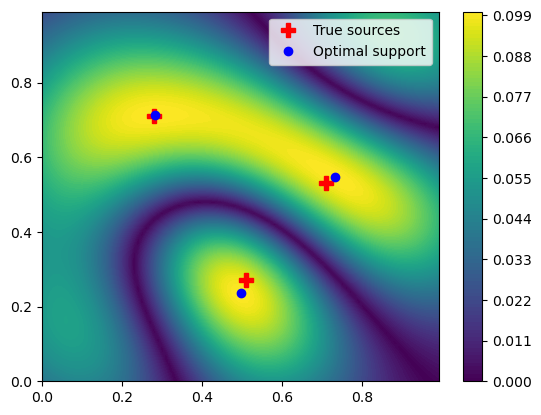

In [160]:
u_tilde = u #Measure(support=[[0.16189578,0.67106819],[0.22222222,0.77777778],[0.33333333,0.66666667],[0.33333333,0.77777778],[0.44444444,0.22222222],[0.44444444,0.33333333],[0.5129322,0.21945235],[0.66666667,0.55555556],[0.77777778,0.44444444],[0.77777778,0.55555556],[0.88888889,0.88888889]], coefficients=[0.12089905,0.30391103,0.5035049,0.13645795,-0.11020099,-0.09355168,-0.43700644,0.23772164,0.05493194,0.41683878,-0.00129572])
P = lambda x: np.abs(p(u_tilde)(x))
a = np.arange(0,1,0.01)
B, D = np.meshgrid(a,a)
vals = np.array([P(np.array([x_1,x_2])) for x_1, x_2 in zip(B.flatten(), D.flatten())]).reshape((100,100))

plt.contourf(B, D, vals, levels=100);
plt.colorbar();
for i, x in enumerate(true_sources):
    if i:
        plt.plot([x[0]], [x[1]], "P", c="r", markersize=10);
    else:
        plt.plot([x[0]], [x[1]], "P", c="r", markersize=10, label="True sources");
for i, x in enumerate(u_tilde.support):
    if i:
        plt.plot([x[0]], [x[1]], "o", c="b");
    else:
        plt.plot([x[0]], [x[1]], "o", c="b", label="Optimal support");
plt.legend();

In [ ]:
residuals_pdap = np.array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903637e+00,
       2.29592885e-01, 1.29111896e-01, 6.02585416e-02, 5.81289511e-02,
       5.43698663e-02, 4.28609944e-02, 2.43456506e-02, 2.24655450e-02,
       2.19692477e-02, 1.97512431e-02, 1.45352926e-02, 1.17524225e-02,
       8.37236219e-03, 8.03803924e-03, 7.27480805e-03, 5.49766940e-03,
       4.74499601e-03, 4.33283626e-03, 3.06984423e-03, 3.03428444e-03,
       2.57014217e-03, 2.25412097e-03, 2.23311015e-03, 1.77761534e-03,
       1.74648392e-03, 1.02712747e-03, 1.00858178e-03, 7.05155587e-04,
       4.57693388e-04, 3.73211977e-04, 3.33190169e-04, 3.26992818e-04,
       3.19892471e-04, 2.76244554e-04, 2.23205519e-04, 2.02456251e-04,
       1.54179999e-04, 1.15910020e-04, 8.64004635e-05, 6.07039715e-05,
       5.67239423e-05, 4.57612933e-05, 4.45947156e-05, 4.10278346e-05,
       3.04747041e-05, 1.81648547e-05, 1.30623802e-05, 1.09291962e-05,
       1.01616338e-05, 9.32082142e-06, 8.04376060e-06, 5.27265804e-06,
       4.24350106e-06, 3.14343762e-06, 2.27059929e-06, 2.09985738e-06,
       1.54896072e-06, 1.32282125e-06, 1.21863744e-06, 7.01233287e-07,
       5.11486209e-07, 4.95514206e-07, 2.81617279e-07, 2.65567768e-07,
       2.43879422e-07, 2.04779396e-07, 1.51890925e-07, 1.42716877e-07,
       1.19812765e-07, 1.02445856e-07, 8.55149913e-08, 6.41045810e-08,
       4.00090262e-08, 2.96556831e-08, 2.79020478e-08, 2.69369642e-08,
       1.81602879e-08, 1.71166652e-08, 1.21881394e-08, 1.17864383e-08,
       1.04790117e-08, 9.05216649e-09, 4.49363047e-09, 3.01657258e-09,
       2.25289737e-09, 2.06415632e-09, 1.99860692e-09, 1.73256048e-09,
       1.58690044e-09, 1.27680713e-09, 7.37280514e-10, 6.21189405e-10,
       4.89523699e-10, 4.03466427e-10, 3.88577309e-10, 3.23766541e-10,
       2.21340918e-10, 1.92937943e-10, 1.74564446e-10, 1.35842587e-10,
       1.18576315e-10, 1.17380605e-10, 1.12498011e-10, 7.33487993e-11,
       5.95664351e-11, 4.00955380e-11, 2.89449575e-11, 2.78584655e-11,
       2.63060129e-11, 2.39317455e-11, 1.88672966e-11, 1.02538533e-11,
       3.56650820e-12, 3.34099415e-12, 2.91480728e-12, 2.88219448e-12,
       1.97503125e-12, 1.42388878e-12, 1.15843446e-12, 1.14247500e-12,
       9.86460913e-13, 8.84708973e-13, 8.19649904e-13, 7.89868171e-13,
       7.33690886e-13, 4.35984582e-13, 4.01789713e-13, 2.69340106e-13,
       2.52603494e-13, 2.21656027e-13, 2.13412621e-13, 1.58428826e-13,
       1.37279077e-13, 1.08635323e-13, 6.98607838e-14, 6.61692923e-14,
       5.50948176e-14, 3.89133170e-14, 3.08642001e-14, 2.64788191e-14,
       2.05391260e-14, 1.61815006e-14, 1.58206781e-14, 1.15740750e-14,
       6.77236045e-15, 2.33146835e-15])

times_pdap = np.array([2.38418579e-07, 4.53706264e-01, 9.27096128e-01, 1.40432858e+00,
       1.88521719e+00, 2.51944041e+00, 3.05500627e+00, 3.56358933e+00,
       4.08990955e+00, 4.61842442e+00, 5.21633482e+00, 5.84030795e+00,
       6.34057927e+00, 6.80048609e+00, 7.29537439e+00, 7.80027580e+00,
       8.29169369e+00, 8.77746987e+00, 9.26843262e+00, 9.75599408e+00,
       1.03222053e+01, 1.09156394e+01, 1.14361475e+01, 1.18833761e+01,
       1.23413351e+01, 1.28029788e+01, 1.32692134e+01, 1.37113070e+01,
       1.42245631e+01, 1.47049112e+01, 1.51560345e+01, 1.56311834e+01,
       1.60974216e+01, 1.65677507e+01, 1.70256970e+01, 1.74750354e+01,
       1.79271338e+01, 1.83822894e+01, 1.88386552e+01, 1.94864688e+01,
       2.00261183e+01, 2.05084424e+01, 2.09907329e+01, 2.16012576e+01,
       2.21181920e+01, 2.27581513e+01, 2.33377709e+01, 2.38085351e+01,
       2.42744792e+01, 2.48410735e+01, 2.53730607e+01, 2.59617853e+01,
       2.65504203e+01, 2.70699439e+01, 2.76257725e+01, 2.81376014e+01,
       2.87197669e+01, 2.92918031e+01, 2.97901638e+01, 3.02486291e+01,
       3.07755232e+01, 3.13416898e+01, 3.19387627e+01, 3.25605047e+01,
       3.31181276e+01, 3.36525857e+01, 3.41956663e+01, 3.48037486e+01,
       3.53290529e+01, 3.59848745e+01, 3.66172097e+01, 3.71689169e+01,
       3.77915747e+01, 3.84515481e+01, 3.90151465e+01, 3.94919851e+01,
       3.99745891e+01, 4.04525130e+01, 4.09281790e+01, 4.14048355e+01,
       4.18889763e+01, 4.23584640e+01, 4.28449926e+01, 4.33356671e+01,
       4.40252583e+01, 4.45619972e+01, 4.52335072e+01, 4.58957427e+01,
       4.64647522e+01, 4.69204173e+01, 4.73833227e+01, 4.78405311e+01,
       4.83362472e+01, 4.88120966e+01, 4.92668283e+01, 4.97124388e+01,
       5.01976273e+01, 5.07069373e+01, 5.12782476e+01, 5.18426542e+01,
       5.24076445e+01, 5.29598258e+01, 5.34358356e+01, 5.39837067e+01,
       5.45343497e+01, 5.51430500e+01, 5.57202127e+01, 5.63005171e+01,
       5.68770173e+01, 5.73669646e+01, 5.79934483e+01, 5.86489022e+01,
       5.92856619e+01, 5.99396615e+01, 6.04499917e+01, 6.09800882e+01,
       6.15748253e+01, 6.21593046e+01, 6.26824200e+01, 6.32250965e+01,
       6.38047009e+01, 6.44569688e+01, 6.50097861e+01, 6.55890660e+01,
       6.62251027e+01, 6.68861938e+01, 6.74289520e+01, 6.79487309e+01,
       6.84411302e+01, 6.90077834e+01, 6.95313387e+01, 7.00382905e+01,
       7.05207031e+01, 7.10119891e+01, 7.15009296e+01, 7.19861476e+01,
       7.26088431e+01, 7.32713518e+01, 7.37827775e+01, 7.44024282e+01,
       7.49937429e+01, 7.55622735e+01, 7.61101401e+01, 7.66819148e+01,
       7.73453050e+01, 7.78587754e+01, 7.86342115e+01, 7.91791565e+01,
       7.98270254e+01, 8.03346059e+01])

supports_pdap = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 7, 8, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9,
       8, 9, 8, 8, 9, 8, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 7, 8, 8, 8, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 9,
       9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 9, 8, 9, 9])

residuals_newton = np.array([ 2.56626430e+01,  2.56626430e+01,  1.74606299e+01,  5.05470051e+00,
        4.89062393e+00,  4.89010890e+00,  4.34012717e+00,  2.57954034e+00,
        2.46278057e+00,  2.45311211e+00,  2.45047563e+00,  1.37210241e+00,
        2.25970925e-01,  9.46248236e-02,  9.35884195e-02,  3.21552724e-02,
        2.53237027e-03,  2.37351925e-03,  2.28676260e-03,  1.03192011e-03,
        7.17546127e-05,  6.70808351e-05,  7.01373085e-03,  2.91460001e-05,
        2.90653696e-09,  2.90653757e-09, -3.46944695e-15])

times_newton = np.array([7.15255737e-07, 9.65309143e-03, 2.40828991e-02, 3.09450626e-02,
       3.70595455e-02, 5.00686169e-02, 6.35924339e-02, 6.95402622e-02,
       7.57000446e-02, 8.20293427e-02, 9.56485271e-02, 1.12404585e-01,
       1.39577150e-01, 1.66254759e-01, 1.78715706e-01, 1.84191942e-01,
       7.08003044e-01, 1.18844914e+00, 1.75794649e+00, 1.78363061e+00,
       2.33380532e+00, 2.80413079e+00, 2.81504703e+00, 2.82054257e+00,
       3.29183769e+00, 3.46994400e+00, 3.99149084e+00])

supports_newton = np.array([0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 4, 5, 6, 6, 5, 6, 7, 6, 6, 7,
       4, 4, 3, 3, 3])

intervals_newton = np.array([[ 1.5,  4.5],
       [ 5.5, 10.5],
       [13.5, 15.5],
       [21.5, 23.5],
       [24.5, 25.5]])

residuals_newton_damped = np.array([ 2.56626430e+01,  2.56626430e+01,  1.74606299e+01,  1.59556125e+01,
        1.46006495e+01,  1.33776930e+01,  1.22753761e+01,  1.12845081e+01,
        1.03968791e+01,  9.60485702e+00,  8.90122927e+00,  8.27913165e+00,
        7.73201400e+00,  7.25362160e+00,  6.83798438e+00,  6.47940999e+00,
        6.17247893e+00,  5.91204096e+00,  5.69321212e+00,  5.51137241e+00,
        5.36216392e+00,  5.24148950e+00,  5.14551215e+00,  5.07065532e+00,
        5.01360428e+00,  4.97130886e+00,  4.94098782e+00,  4.92013480e+00,
        4.90652602e+00,  4.89822905e+00,  4.89361191e+00,  4.89135099e+00,
        4.89043497e+00,  4.89016059e+00,  4.89011206e+00,  3.13259275e+00,
        2.73039295e+00,  2.11989567e+00,  1.72060471e+00,  1.40539010e+00,
        1.14583499e+00,  9.29851543e-01,  7.49695470e-01,  5.99717572e-01,
        4.75444893e-01,  3.73142908e-01,  2.89592405e-01,  2.21969734e-01,
        1.67779467e-01,  1.24815174e-01,  9.11363231e-02,  6.50549364e-02,
        4.51275036e-02,  3.01473182e-02,  1.91309838e-02,  1.12922891e-02,
        5.99940138e-03,  2.71838994e-03,  9.55220665e-04,  1.68619127e-05,
        1.64040502e-05,  3.31479504e-07,  4.51515376e-03,  2.59542089e-03,
        1.38103304e-03,  6.62858940e-04,  2.75846533e-04,  9.32742530e-05,
        2.28242669e-05,  3.21104956e-06,  1.54953142e-07,  7.32976374e-10,
        1.79023463e-14, -3.49720253e-15])

times_newton_damped = np.array([2.38418579e-07, 5.41281700e-03, 1.76355839e-02, 2.41577625e-02,
       3.03523540e-02, 3.67414951e-02, 4.75833416e-02, 5.32751083e-02,
       5.88154793e-02, 6.43019676e-02, 7.04236031e-02, 8.16042423e-02,
       8.74774456e-02, 9.34922695e-02, 9.99310017e-02, 1.05723381e-01,
       1.16555452e-01, 1.22693539e-01, 1.29113674e-01, 1.34928942e-01,
       1.40502930e-01, 1.51169777e-01, 1.57197714e-01, 1.63335800e-01,
       1.69991016e-01, 1.75750971e-01, 1.87001228e-01, 1.92858219e-01,
       1.99265242e-01, 2.05387831e-01, 2.11197376e-01, 2.24167824e-01,
       2.30447531e-01, 2.38195419e-01, 2.44183064e-01, 2.60089874e-01,
       2.72747278e-01, 2.79483318e-01, 2.85110712e-01, 2.89981604e-01,
       3.06290388e-01, 3.11129808e-01, 3.18518400e-01, 3.23826551e-01,
       3.29535246e-01, 3.42664242e-01, 3.49350452e-01, 3.55810642e-01,
       3.61460447e-01, 3.68844509e-01, 3.80911350e-01, 3.88760090e-01,
       3.94061089e-01, 4.00561333e-01, 4.05778885e-01, 4.16984320e-01,
       4.24430132e-01, 4.30547953e-01, 4.37543869e-01, 9.82669115e-01,
       1.48541594e+00, 2.00977755e+00, 2.02155161e+00, 2.02824545e+00,
       2.03402400e+00, 2.04155016e+00, 2.05630207e+00, 2.06139708e+00,
       2.06721854e+00, 2.07559347e+00, 2.08206773e+00, 2.09795380e+00,
       2.10341716e+00, 2.62918544e+00])

supports_newton_damped = np.array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3])

intervals_newton_damped = np.array([[ 1.5, 34.5],
       [35.5, 58.5],
       [61.5, 72.5]])

residuals_lpdap = np.array([2.56626430e+01, 5.68389440e+00, 5.46356874e+00, 2.51910533e+00,
       2.51910533e+00, 2.51910533e+00, 2.51910533e+00, 2.51910533e+00,
       2.51910533e+00, 2.51910533e+00, 2.51910533e+00, 2.51910533e+00,
       2.49298189e+00, 1.52469505e+00, 1.33945183e+00, 1.29802114e+00,
       8.46074183e-01, 5.13466532e-01, 4.14884802e-01, 3.91024809e-01,
       1.55155639e-01, 3.95412377e-02, 3.13866705e-02, 2.94766280e-02,
       2.82051874e-02, 2.82051874e-02, 2.82051874e-02, 2.82051874e-02,
       2.82051874e-02, 2.82051874e-02, 2.82051874e-02, 2.28594819e-02,
       1.96873290e-02, 1.86097853e-02, 1.70658195e-02, 1.07843188e-02,
       7.21661241e-03, 6.90838599e-03, 6.90838599e-03, 6.90838599e-03,
       6.90838599e-03, 6.90838599e-03, 4.05954674e-03, 4.03998724e-03,
       4.03998724e-03, 3.83862111e-03, 2.63344418e-03, 2.55210054e-03,
       2.05861557e-03, 1.62410716e-03, 1.06210969e-03, 1.02890516e-03,
       1.01916643e-03, 6.35489620e-04, 6.35489620e-04, 5.59247030e-04,
       4.50894000e-04, 4.50894000e-04, 4.50894000e-04, 4.50894000e-04,
       4.50894000e-04, 4.50894000e-04, 4.50894000e-04, 3.19334822e-04,
       1.95725839e-04, 1.94611049e-04, 1.94611049e-04, 1.68309530e-04,
       1.62387493e-04, 1.61540373e-04, 1.58493578e-04, 1.52436769e-04,
       1.26274674e-04, 1.26274674e-04, 1.26274674e-04, 1.26274674e-04,
       1.12645777e-04, 4.75008332e-05, 4.40195331e-05, 3.35243631e-05,
       3.21126351e-05, 2.70087124e-05, 2.12298984e-05, 1.60615027e-05,
       1.44405993e-05, 1.19995909e-05, 9.66906456e-06, 8.56277636e-06,
       7.30605832e-06, 5.16847710e-06, 4.90297789e-06, 3.40374363e-06,
       2.02184438e-06, 1.57535707e-06, 1.43420103e-06, 1.27516411e-06,
       1.00231272e-06, 9.36301069e-07, 8.36750554e-07, 4.96138884e-07,
       4.65841269e-07, 4.57189363e-07, 3.19139531e-07, 2.75167308e-07,
       2.25837465e-07, 1.10225716e-07, 1.08412839e-07, 1.05711323e-07,
       9.57031077e-08, 6.31791362e-08, 3.04939817e-08, 2.19990949e-08,
       9.16929743e-09, 6.38451164e-09, 2.54851606e-09, 2.04389899e-09,
       1.46968163e-09, 6.31119101e-10, 4.88495078e-10, 2.86066504e-10,
       8.30503166e-11, 5.20881671e-11, 2.22703522e-11, 2.13238593e-11,
       9.12281362e-12, 3.67084141e-12, 2.08411066e-12, 9.57706137e-13,
       7.38020756e-13, 5.68434189e-13, 1.57651669e-13, 1.49658064e-13,
       8.29336599e-14, 6.04238881e-14, 4.22717417e-14, 2.19269047e-15,
       9.43689571e-16, 8.60422844e-16, 8.04911693e-16, 7.77156117e-16,
       6.93889390e-16])

times_lpdap = np.array([2.43186951e-03, 2.24134922e-02, 4.97074127e-02, 6.70232773e-02,
       8.06725025e-02, 9.26663876e-02, 1.03285313e-01, 1.18788719e-01,
       1.29771709e-01, 1.40192032e-01, 1.51462555e-01, 1.61025524e-01,
       1.82733774e-01, 1.94938183e-01, 2.08823204e-01, 2.27992058e-01,
       2.43440866e-01, 2.57202148e-01, 2.70761013e-01, 2.90256500e-01,
       3.14153433e-01, 3.36939573e-01, 3.58320475e-01, 3.82315397e-01,
       1.03577876e+00, 1.55664825e+00, 2.18835521e+00, 2.74982500e+00,
       3.31979847e+00, 3.82694697e+00, 4.30355740e+00, 4.31906104e+00,
       4.33344698e+00, 4.34934235e+00, 4.36340761e+00, 4.84839106e+00,
       4.86451626e+00, 4.88130379e+00, 4.89639401e+00, 4.91110802e+00,
       4.92838740e+00, 4.94672990e+00, 4.97623706e+00, 5.56060076e+00,
       6.23879528e+00, 6.25956225e+00, 6.28046155e+00, 6.29727793e+00,
       6.84683204e+00, 6.86595392e+00, 6.88634253e+00, 6.90331817e+00,
       6.92397332e+00, 6.94502521e+00, 6.96163368e+00, 7.47667742e+00,
       7.49441648e+00, 7.50842667e+00, 7.52231312e+00, 7.53805590e+00,
       7.55527377e+00, 7.57136536e+00, 7.58516097e+00, 7.60692835e+00,
       7.62934923e+00, 8.12227559e+00, 8.60513282e+00, 8.62490368e+00,
       8.64329863e+00, 8.65998721e+00, 8.67401886e+00, 8.69140148e+00,
       8.71194792e+00, 8.73050094e+00, 8.74965954e+00, 8.77185464e+00,
       8.79090214e+00, 9.29604006e+00, 9.31631899e+00, 9.33669043e+00,
       9.35929441e+00, 9.86780596e+00, 9.89094687e+00, 9.91147876e+00,
       9.93464422e+00, 1.04488585e+01, 1.04689021e+01, 1.04872663e+01,
       1.05091679e+01, 1.10133359e+01, 1.10272872e+01, 1.10484769e+01,
       1.15533195e+01, 1.15726364e+01, 1.15869453e+01, 1.16090951e+01,
       1.16288798e+01, 1.21158142e+01, 1.21383364e+01, 1.21599710e+01,
       1.21780257e+01, 1.26791608e+01, 1.27004616e+01, 1.27219753e+01,
       1.32261868e+01, 1.32483728e+01, 1.32669661e+01, 1.32812917e+01,
       1.37960193e+01, 1.38188241e+01, 1.38531816e+01, 1.43590450e+01,
       1.43870180e+01, 1.48783019e+01, 1.49022822e+01, 1.55465660e+01,
       1.55724900e+01, 1.60648246e+01, 1.60898530e+01, 1.66020494e+01,
       1.66331258e+01, 1.71364386e+01, 1.76324365e+01, 1.76456230e+01,
       1.81234508e+01, 1.81465628e+01, 1.86463673e+01, 1.86716199e+01,
       1.86977241e+01, 1.92233651e+01, 1.92552500e+01, 1.97626565e+01,
       1.97866311e+01, 1.98133283e+01, 2.03697495e+01, 2.08734984e+01,
       2.08934374e+01, 2.09095211e+01, 2.09254959e+01, 2.14208527e+01,
       2.14402628e+01])

supports_lpdap = np.array([ 0,  1,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  5,  6,  6,
        7,  7,  8,  8,  6,  7,  8,  9,  9,  9,  9,  9,  9,  9,  8,  8,  8,
        9,  9,  9,  9,  9,  9,  9,  9,  8,  9,  9,  8,  7,  8,  7,  7,  7,
        8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  8,  9,  9,  7,
        7,  8,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  8,  8,  8,  9,  9,  9,  8,  8,  8,  8,  9,
        9,  9,  9,  8,  8,  9,  9,  8,  7,  9,  9,  8,  8,  8,  9,  9,  9,
        9,  8,  8,  8,  9,  8,  9,  8,  8,  8,  8,  8,  9,  9, 10, 10, 12,
       12, 13, 14, 15, 18])

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([residuals_pdap, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Total iterations");
plt.ylim(1e-14, 30);
# plt.xlim(0, 135);
plt.legend();

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([supports_pdap, supports_lpdap, supports_newton, supports_newton_damped], names, styles):
    plt.plot(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Support size");
plt.xlabel("Total iterations");
plt.legend();

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for domain, array, name, style in zip([times_pdap, times_lpdap, times_newton, times_newton_damped], [residuals_pdap, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(domain, array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Time (s)");
plt.ylim(1e-14, 30);
# plt.xlim(0, 60);
plt.legend();

In [ ]:
plt.figure(figsize=(11.25,5))
plt.semilogy(np.array(range(len(residuals_newton))), residuals_newton);
for interval in intervals_newton:
    plt.fill_between(interval, 0, 30, color='green', alpha=0.25);
plt.ylim(1e-12, 30);
plt.xlabel("Total iterations");

# Signal Processing

## Generate Data and Define Functions

In [165]:
observation_resolution = 120
Omega = np.array([[0,observation_resolution//2]])
alpha = 1e-1
true_sources = np.array([[3.125], [7], [np.sqrt(179)]])
true_weights = np.array([-1, 0.7, 0.5])

In [166]:
observations = np.arange(0,1,1/observation_resolution)

In [167]:
def kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    columns = []
    for t in observations:
        column = np.sin(2*np.pi*x*t).flatten()
        columns.append(column)
    result = np.transpose(np.array(columns), axes=(1,0)) # shape=(len(x), len(observations))
    return result

In [168]:
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(kappa)

In [169]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(kappa) - target) ** 2

In [170]:
def grad_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    gradients = []
    for t in observations:
        factor = 2*np.pi*t
        column = np.cos(2*np.pi*x*t) # (len(x), Omega.shape[0])
        gradient = factor * column
        gradients.append(gradient)
    result = np.transpose(np.array(gradients), axes=(1,0,2)) # The Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0])
    return result

In [171]:
def hess_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    hessians = []
    for t in observations:
        factor = -4*np.pi**2*t**2
        column = np.sin(2*np.pi*x*t).reshape(-1,1,1) # (len(x), Omega.shape[0], Omega.shape[0])
        hessian = factor * column
        hessians.append(hessian)
    result = np.transpose(np.array(hessians), axes=(1,0,2,3)) # The derivative of the Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0], Omega.shape[0])
    return result

In [172]:
def p_raw(u):
    Ku = u.duality_pairing(kappa)
    inner = Ku-target
    return lambda x: -kappa(x) @ inner

p = lambda u: p_raw(u)

In [173]:
def grad_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1)*np.tensordot(grad_kappa(x), inner, axes=([1,0]))

grad_P = lambda u: grad_P_raw(u)

In [174]:
def hess_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1,1)*np.tensordot(hess_kappa(x),inner,axes=([1,0]))

hess_P = lambda u: hess_P_raw(u)

In [175]:
def grad_j(positions, coefs):
    K_matrix = kappa(positions)
    grad_F = (K_matrix.T@coefs).flatten() - target
    nabla_x = coefs.reshape(-1,1)*np.tensordot(grad_kappa(positions), grad_F, axes=([1,0]))
    nabla_u = np.dot(K_matrix, grad_F) + alpha * np.sign(coefs)
    return np.append(nabla_x.flatten(), nabla_u, axis=0).flatten()

In [176]:
def hess_j(positions, coefs):
    kappa_values = kappa(positions)
    grad_kappa_values = grad_kappa(positions)
    hess_kappa_values = hess_kappa(positions)
    matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
    hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
    step = Omega.shape[0]
    coefs_delay = step*len(positions)
    inner = (kappa_values.T@coefs).flatten() - target
    for i in range(len(positions)):
        # nabla_{x_i,x_j}
        for j in range(len(positions)):
            if j<i:
                continue
            block = coefs[i]*coefs[j]*np.matmul(grad_kappa_values[i].T, grad_kappa_values[j])
            if i==j:
                block += coefs[i]*np.tensordot(hess_kappa_values[i],inner,axes=([0,0]))
            hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
            hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
        # nabla_{x_i,u_j}
        for j in range(len(coefs)):
            block = coefs[i]*np.matmul(grad_kappa_values[i].T, kappa_values[j])
            if i == j:
                block += np.matmul(grad_kappa_values[i].T, inner)
            hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
            hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
    for i in range(len(coefs)):
        # nabla_{u_i,u_j}
        for j in range(len(coefs)):
            if j<i:
                continue
            block = np.dot(kappa_values[i], kappa_values[j])
            hesse_matrix[coefs_delay+i,coefs_delay+j] = block
            hesse_matrix[coefs_delay+j,coefs_delay+i] = block
    return hesse_matrix

In [177]:
a = np.arange(Omega[0][0], Omega[0][1], 0.1).reshape(-1,1)
vals = np.linalg.norm(kappa(a), axis=1)
norm_K_star = max(vals)
norm_K_star

8.436705235037092

In [178]:
a = np.arange(Omega[0][0], Omega[0][1], 0.1).reshape(-1,1)
vals = np.linalg.norm(grad_kappa(a), axis=(1,2))
norm_K_star_L = max(vals)
norm_K_star_L

39.48990157632303

In [179]:
gamma = 0.5
theta = 1e-1
sigma = 5e-2
m = 1e-3
bar_m = 1e-1
L = 1
L_H = max(np.abs(true_weights))
R = 1e-1
L_H

1.0

## Experiments

In [180]:
exp = LazifiedPDAP(target=target, 
           kappa=kappa, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_K_star=norm_K_star,
           norm_K_star_L=norm_K_star_L,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           gamma=gamma,
           theta=theta,
           sigma=sigma,
           m=m,
           bar_m=bar_m,
           L=L,
           L_H=L_H,
           R=R,
           M=50
           )

### PDAP

In [181]:
u, P_values, times, supports, objective_values = exp.pdap(tol=1e-15)

DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:1: Phi:2.102E+03, support: [[3.13588856]], coefs: [-1.02219696], x: [7.00005078]
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:2: Phi:1.497E+03, support: [[3.13588856]
 [7.00005078]], coefs: [-0.99145093  0.70208178], x: [13.38203765]
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:3: Phi:9.018E+01, support: [[ 3.13588856]
 [ 7.00005078]
 [13.38203765]], coefs: [-0.99785308  0.69586351  0.49867157], x: [2.81555416]
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:4: Phi:3.918E+01, support: [[ 2.81555416]
 [ 3.13588856]
 [ 7.00005078]
 [13.38203765]], coefs: [-0.03816109 -0.97952737  0.69852898  0.49805815

In [182]:
best = objective_values[-1]

In [183]:
np.array(times[:70])

array([4.76837158e-07, 7.55987167e-02, 1.44138813e-01, 2.29179621e-01,
       3.11399937e-01, 3.74093533e-01, 4.60531712e-01, 5.26333809e-01,
       5.87925434e-01, 6.56133652e-01, 7.17153549e-01, 7.89391041e-01,
       8.57702494e-01, 9.32289600e-01, 9.99001741e-01, 1.06422663e+00,
       1.14311266e+00, 1.21030688e+00, 1.30092978e+00, 1.38627720e+00,
       1.47628164e+00, 1.55514193e+00, 1.61602998e+00, 1.67783093e+00,
       1.73872161e+00, 1.80089688e+00, 1.86205459e+00, 1.92793536e+00,
       1.99085760e+00, 2.05435944e+00, 2.11879730e+00, 2.18593049e+00,
       2.26515818e+00, 2.36023307e+00, 2.45533037e+00, 2.53813624e+00,
       2.61046243e+00, 2.68093848e+00, 2.77535367e+00, 2.86958218e+00,
       2.96540666e+00, 3.04429960e+00, 3.13450551e+00, 3.22629833e+00,
       3.30013418e+00, 3.38334084e+00, 3.44820952e+00, 3.51639128e+00,
       3.59842014e+00, 3.68533397e+00, 3.77941513e+00, 3.87127113e+00,
       3.96257639e+00, 4.03558230e+00, 4.11157560e+00, 4.20902038e+00,
      

In [184]:
np.array(supports[:70])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  9,  9,  8,  7,  7,  7,
        5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6])

In [185]:
objective_values[:70]-best

array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388053e-02,
       1.50239775e-02, 8.58376252e-03, 6.60215205e-03, 6.26160457e-03,
       5.81056957e-03, 5.68714554e-03, 5.63453913e-03, 2.74798167e-03,
       2.49625307e-03, 2.43692854e-03, 1.09428955e-03, 1.06241337e-03,
       9.64583831e-04, 3.70010641e-04, 3.28227689e-04, 3.27716481e-04,
       1.08225418e-04, 8.89059417e-05, 8.85996713e-05, 2.08581055e-05,
       1.15859896e-05, 1.14112380e-05, 8.58446562e-06, 4.06824489e-06,
       3.96465445e-06, 2.55842288e-06, 1.39500359e-06, 1.33895639e-06,
       6.37729847e-07, 3.72191366e-07, 3.43278990e-07, 1.86417489e-07,
       1.07770633e-07, 9.30291466e-08, 4.47906140e-08, 3.13019601e-08,
       2.38731743e-08, 1.63321595e-08, 9.87044582e-09, 6.13793091e-09,
       2.36218450e-09, 2.29294733e-09, 4.22667956e-10, 3.32072064e-10,
       2.96452390e-10, 1.96911765e-10, 1.51274798e-10, 1.33153821e-10,
       8.30943370e-11, 6.01874106e-11, 5.10491927e-11, 2.59471611e-11,
      

In [186]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502169]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502184]
 [ 6.99999252]
 [ 6.99999252]
 [ 6.99999252]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999264]
 [13.37905646]
 [13.37905646]
 [13.37905646]
 [13.37905647]
 [13.37905649]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905653]
 [13.37905653]] and coefficients [-6.04213397e-01 -1.86861913e-02 -2.27343649e-02 -2.58792978e

### Newton

In [93]:
u, times, supports, inner_loop, inner_lazy, inner_total, outer_lazy, outer_total, objective_values = exp.newton(tol=1e-12, damped=False)

INFO:root:1: choice: 0, lazy: True, support: [], epsilon: 0.5291269403006611, objective: 5.291E+01
INFO:root:True, True, True, True, True
INFO:root:2, 1: lazy: True, support: [[3.10517529]], coefs: [-0.20775711], epsilon: 0.5291269403006611, objective: 4.188E+01
INFO:root:True, True, True, True, True
INFO:root:2, 2: lazy: N/A, support: [[3.27164622]], coefs: [-1.08547986], epsilon: 0.5291269403006611, objective: 3.112E+01
INFO:root:True, True, True, True, True
INFO:root:2, 3: lazy: N/A, support: [[3.05511777]], coefs: [-1.30703184], epsilon: 0.5291269403006611, objective: 2.871E+01
INFO:root:True, True, True, True, True
INFO:root:2, 4: lazy: N/A, support: [[3.12602412]], coefs: [-1.06623658], epsilon: 0.5291269403006611, objective: 2.260E+01
INFO:root:True, True, True, True, True
INFO:root:2, 5: lazy: True, support: [[3.13547144]], coefs: [-1.02299012], epsilon: 0.5291269403006611, objective: 2.250E+01
INFO:root:True, True, False, True, True
DEBUG:root:SSN in 2 dimensions converged in 

In [94]:
objective_values-best

array([ 5.26929402e+01,  5.26929402e+01,  4.16628616e+01,  3.09029774e+01,
        2.84925698e+01,  2.23790151e+01,  2.22758082e+01,  7.51520858e+00,
        4.77281182e+00,  7.72924321e-02,  3.75464937e-01,  2.59752249e-03,
        1.40443125e-03,  1.82277977e-04,  8.01634950e-04,  7.62752916e-09,
       -2.96984659e-15])

In [95]:
np.array(times)

array([2.38418579e-07, 5.12766838e-03, 2.44998932e-02, 3.68676186e-02,
       4.82726097e-02, 5.96280098e-02, 7.75327682e-02, 1.01983070e-01,
       1.21976376e-01, 1.46380901e-01, 1.66143894e-01, 2.69479752e-01,
       2.94684649e-01, 4.21380520e-01, 4.41186190e-01, 4.53345776e-01,
       6.56386375e-01])

In [96]:
np.array(supports)

array([0, 0, 1, 1, 1, 1, 1, 2, 3, 4, 4, 4, 4, 4, 3, 3, 3])

In [97]:
intervals = []
current_inner = False
for ind, i in enumerate(inner_loop):
    if i:
        if not current_inner:
            start = ind-0.5
            current_inner = True
    else:
        if current_inner:
            end = ind-0.5
            intervals.append((start,end))
            current_inner = False
np.array(intervals)

array([[ 1.5,  6.5],
       [ 7.5,  8.5],
       [ 9.5, 10.5],
       [13.5, 15.5]])

In [98]:
print(inner_lazy)
print(inner_total)
print(outer_lazy)
print(outer_total)

7
7
4
7


In [99]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502173]
 [ 6.9999926 ]
 [13.37905649]] and coefficients [-0.99832728  0.69841291  0.49833707]
[4.16333634e-15]
-4.274358644806853e-15


In [100]:
print(np.linalg.norm(np.array([x[0] for x in u.support]) - np.array([x[0] for x in true_sources])))
print(np.linalg.norm(u.coefficients-true_weights))

3.91118849179322e-05
0.002842918769692916


In [101]:
hess = hess_j(u.support, u.coefficients)
np.linalg.eig(hess).eigenvalues

array([841.50400002, 377.40347868, 187.63319262,  56.17717494,
        61.42436526,  60.16886452])

### Newton Damped

In [103]:
u, times, supports, inner_loop, inner_lazy, inner_total, outer_lazy, outer_total, objective_values = exp.newton(tol=1e-12, damped=True, damping_root=1)

INFO:root:1: choice: 0, lazy: True, support: [], epsilon: 0.5291269403006611, objective: 5.291E+01
INFO:root:True, True, True, True, True
INFO:root:2, 1: lazy: True, support: [[3.10517529]], coefs: [-0.20775711], epsilon: 0.5291269403006611, objective: 4.188E+01
INFO:root:True, True, True, True, True
INFO:root:2, 2: lazy: N/A, support: [[3.11351583]], coefs: [-0.25173285], epsilon: 0.5291269403006611, objective: 3.983E+01
INFO:root:True, True, True, True, True
INFO:root:2, 3: lazy: N/A, support: [[3.11847898]], coefs: [-0.2926916], epsilon: 0.5291269403006611, objective: 3.802E+01
INFO:root:True, True, True, True, True
INFO:root:2, 4: lazy: N/A, support: [[3.12184754]], coefs: [-0.33188294], epsilon: 0.5291269403006611, objective: 3.639E+01
INFO:root:True, True, True, True, True
INFO:root:2, 5: lazy: True, support: [[3.12429631]], coefs: [-0.36968854], epsilon: 0.5291269403006611, objective: 3.491E+01
INFO:root:True, True, True, True, True
INFO:root:2, 6: lazy: N/A, support: [[3.126157

In [104]:
objective_values-best

array([ 5.26929402e+01,  5.26929402e+01,  4.16628616e+01,  3.96065862e+01,
        3.78034581e+01,  3.61744035e+01,  3.46903068e+01,  3.33352483e+01,
        3.20982247e+01,  3.09704677e+01,  2.99443907e+01,  2.90131204e+01,
        2.81702685e+01,  2.74098124e+01,  2.67260291e+01,  2.61134569e+01,
        2.55668730e+01,  2.50812785e+01,  2.46518900e+01,  2.42741327e+01,
        2.39436371e+01,  2.36562353e+01,  2.34079599e+01,  2.31950415e+01,
        2.30139082e+01,  2.28611842e+01,  2.27336895e+01,  2.26284386e+01,
        2.25426402e+01,  2.24736967e+01,  2.24192029e+01,  2.23769461e+01,
        2.23449045e+01,  2.23212469e+01,  2.23043313e+01,  2.22927039e+01,
        2.22850971e+01,  2.22804279e+01,  2.22777952e+01,  2.22764757e+01,
        2.22759193e+01,  7.51965812e+00,  4.77697568e+00,  4.05889828e+00,
        3.48568204e+00,  2.98872994e+00,  2.55188018e+00,  2.16708748e+00,
        1.82880914e+00,  1.53255007e+00,  1.27436574e+00,  1.05066214e+00,
        8.58105568e-01,  

In [105]:
np.array(times)

array([2.38418579e-07, 5.28287888e-03, 2.35853195e-02, 3.54704857e-02,
       4.78765965e-02, 5.87825775e-02, 7.79702663e-02, 8.98339748e-02,
       1.04911089e-01, 1.17443562e-01, 1.29444599e-01, 1.47318840e-01,
       1.58570528e-01, 1.69902325e-01, 1.80325747e-01, 1.91695213e-01,
       2.10273504e-01, 2.21727610e-01, 2.33033419e-01, 2.44600296e-01,
       2.56171465e-01, 2.74013519e-01, 2.82650948e-01, 2.91655540e-01,
       3.00678015e-01, 3.10712337e-01, 3.31666231e-01, 3.45450640e-01,
       3.59389067e-01, 3.71105194e-01, 3.82481575e-01, 4.00247335e-01,
       4.11985159e-01, 4.23377991e-01, 4.38382626e-01, 4.47387695e-01,
       4.61266518e-01, 4.73331451e-01, 4.85872269e-01, 4.97316837e-01,
       5.08586407e-01, 5.40246010e-01, 5.59759378e-01, 5.68410635e-01,
       5.77752352e-01, 5.85857868e-01, 6.01286888e-01, 6.10333681e-01,
       6.25383615e-01, 6.46610260e-01, 6.64915323e-01, 6.85660124e-01,
       6.99043036e-01, 7.12289333e-01, 7.25235462e-01, 7.37868071e-01,
      

In [106]:
np.array(supports)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [107]:
intervals = []
current_inner = False
for ind, i in enumerate(inner_loop):
    if i:
        if not current_inner:
            start = ind-0.5
            current_inner = True
    else:
        if current_inner:
            end = ind-0.5
            intervals.append((start,end))
            current_inner = False
np.array(intervals)

array([[ 1.5, 40.5],
       [41.5, 72.5],
       [73.5, 75.5]])

In [108]:
print(inner_lazy)
print(inner_total)
print(outer_lazy)
print(outer_total)

16
17
2
4


In [109]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502173]
 [ 6.9999926 ]
 [13.37905649]] and coefficients [-0.99832728  0.69841291  0.49833707]
[2.10942375e-15]
2.8033131371785203e-15


### LPDAP

In [187]:
u, Phi_ks, times, supports, objective_values = exp.lpdap(tol=1e-12)

INFO:root:1: Step: GCG, Lazy True, Phi_k: 2.958E+03, epsilon: 5.291E-01, support: [], coefs: []
INFO:root:==============================================
DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 5.000E-04
INFO:root:2: Step: GCG, Lazy True, Phi_k: 1.133E+02, epsilon: 5.291E-01, support: [[3.10517529]], coefs: [-1.01399371]
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 5.000E-04
INFO:root:3: Step: GCG, Lazy True, Phi_k: 1.519E+02, epsilon: 5.291E-01, support: [[3.10517529]
 [4.33089484]], coefs: [-1.00948126 -0.03796282]
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 5.000E-04
INFO:root:4: Step: GCG, Lazy True, Phi_k: 2.648E+02, epsilon: 5.291E-01, support: [[3.10517529]
 [4.33089484]
 [4.75957897]], coefs: [-1.00523456 -0.04672974  0.05261042]
INFO:root:==============================================
D

In [188]:
np.array(times)

array([2.39109993e-03, 3.13935280e-02, 5.46138287e-02, 7.94129372e-02,
       1.09659433e-01, 1.41906500e-01, 1.75046206e-01, 2.03082323e-01,
       2.30102301e-01, 2.56185293e-01, 2.74809122e-01, 2.93889999e-01,
       3.21487904e-01, 3.49608421e-01, 3.76793623e-01, 4.03572321e-01,
       4.22283888e-01, 4.54313278e-01, 4.91884708e-01, 5.19264221e-01,
       5.47992229e-01, 5.80835819e-01, 6.13688469e-01, 6.47420645e-01,
       6.76387787e-01, 7.09716320e-01, 8.29542875e-01, 8.70622873e-01,
       9.09713030e-01, 9.41114902e-01, 9.82822895e-01, 1.02233648e+00,
       1.12132955e+00, 1.20468879e+00, 1.24553227e+00, 1.29007959e+00,
       1.31673384e+00, 1.34286499e+00, 1.36795759e+00, 1.40423274e+00,
       1.44014597e+00, 1.53605676e+00, 1.57314754e+00, 1.59390998e+00,
       1.63027191e+00, 1.66873717e+00, 1.68965244e+00, 1.72717857e+00,
       1.74844599e+00, 1.78956294e+00, 1.83210826e+00, 1.90609741e+00,
       2.02688098e+00, 2.07981110e+00, 2.12466764e+00, 2.16577482e+00,
      

In [189]:
np.array(supports)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9,  9, 10, 11, 12, 13, 13,
       13, 13, 14, 14, 15, 14, 13, 14, 14, 15, 16, 17, 17, 17, 18, 18, 18,
       18, 17, 17, 17, 17, 18, 19, 20, 21, 21, 21, 21, 21, 21, 21, 20, 21,
       22, 23, 23, 23, 23, 20, 19, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21,
       18, 18, 18, 14, 14, 14, 11, 12, 10,  7,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  9])

In [190]:
objective_values-best

array([5.26929402e+01, 2.27036009e+01, 2.26605773e+01, 2.25806762e+01,
       2.23448181e+01, 2.21862100e+01, 2.20597114e+01, 2.19901639e+01,
       2.18877061e+01, 2.17743791e+01, 2.17743791e+01, 2.17743791e+01,
       2.16118716e+01, 2.10100782e+01, 2.09378375e+01, 2.08786883e+01,
       2.08786883e+01, 2.08550747e+01, 7.28295921e+00, 7.27376812e+00,
       7.25614504e+00, 7.15466911e+00, 2.09473986e-01, 1.99132637e-01,
       1.01597485e-01, 4.29346707e-02, 3.53640755e-02, 3.42981497e-02,
       3.40667845e-02, 3.21742675e-02, 3.15616990e-02, 3.05762946e-02,
       2.79615785e-02, 2.79615785e-02, 2.77337243e-02, 2.09504226e-02,
       2.09504226e-02, 2.09504226e-02, 2.09504226e-02, 2.08392701e-02,
       2.07437405e-02, 2.06839363e-02, 2.06352573e-02, 2.06352573e-02,
       2.00074417e-02, 1.88549465e-02, 1.88549465e-02, 1.70487614e-02,
       1.70487614e-02, 1.16910132e-02, 1.15873964e-02, 1.15696382e-02,
       1.15317655e-02, 1.15195337e-02, 1.15077243e-02, 1.14829898e-02,
      

In [191]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.1250215 ]
 [ 3.12502172]
 [ 3.12502178]
 [ 6.99999242]
 [ 6.99999258]
 [ 6.99999275]
 [13.37905643]
 [13.37905662]
 [13.3790568 ]] and coefficients [-0.16284576 -0.09293144 -0.74255007  0.26335611  0.07539454  0.35966226
  0.36622886  0.09153653  0.04057168]
[1.90403249e-14]
1.0907941216942163e-14


## Plots

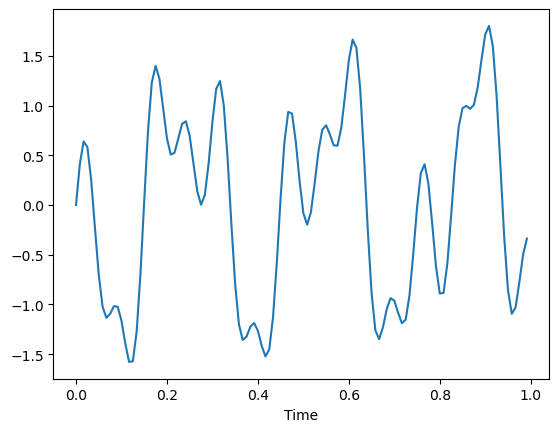

In [119]:
plt.plot(observations, target);
plt.xlabel("Time");

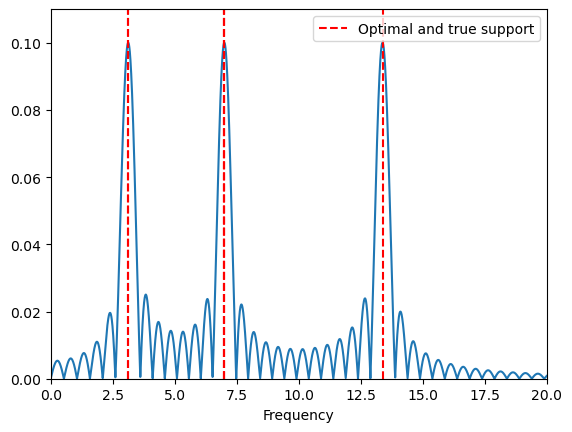

In [130]:
u_tilde = u # Measure(support=[[1.00840336],[1.51260504],[2.01680672],[2.5210084],[3.02521008],[3.52941176],[4.03361345],[4.53781513],[5.04201681],[6.52828034],[7.05882353],[7.56302521],[8.06722689],[8.57142857],[9.07563025],[9.57983193],[10.08403361],[10.58823529],[11.09243697],[11.59663866],[12.10084034],[12.60504202],[13.1092437],[13.61344538],[14.11764706],[14.62184874]], coefficients=[-0.02073555,0.03750054,-0.06643334,0.13918181,-0.92346277,-0.23878818,0.10786171,-0.06783396,0.04578576,0.04158428,0.72923855,-0.11325314,0.07786523,-0.06503374,0.05884924,-0.05590312,0.05517159,-0.05649383,0.06033915,-0.06817023,0.08409641,-0.123255,0.3144845,0.31918172,-0.08787151,0.04497542])
a = np.arange(Omega[0][0],Omega[0][1],0.005)
vals = np.array([np.abs(p(u_tilde)(np.array([x]))) for x in a])
plt.plot(a,vals);
for i, pos in enumerate(u_tilde.support):
    if not i:
        plt.axvline(x=pos, linestyle="--", c="r", label="Optimal and true support");
    else:
        plt.axvline(x=pos, linestyle="--", c="r");
plt.xlabel("Frequency");
plt.ylim(0,0.11);
plt.xlim(0, 20);
plt.legend();

In [ ]:
residuals_pdap = np.array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388053e-02,
       1.50239775e-02, 8.58376252e-03, 6.60215205e-03, 6.26160457e-03,
       5.81056957e-03, 5.68714554e-03, 5.63453913e-03, 2.74798167e-03,
       2.49625307e-03, 2.43692854e-03, 1.09428955e-03, 1.06241337e-03,
       9.64583831e-04, 3.70010641e-04, 3.28227689e-04, 3.27716481e-04,
       1.08225418e-04, 8.89059417e-05, 8.85996713e-05, 2.08581055e-05,
       1.15859896e-05, 1.14112380e-05, 8.58446562e-06, 4.06824489e-06,
       3.96465445e-06, 2.55842288e-06, 1.39500359e-06, 1.33895639e-06,
       6.37729847e-07, 3.72191366e-07, 3.43278990e-07, 1.86417489e-07,
       1.07770633e-07, 9.30291466e-08, 4.47906140e-08, 3.13019601e-08,
       2.38731743e-08, 1.63321595e-08, 9.87044582e-09, 6.13793091e-09,
       2.36218450e-09, 2.29294733e-09, 4.22667956e-10, 3.32072064e-10,
       2.96452390e-10, 1.96911765e-10, 1.51274798e-10, 1.33153821e-10,
       8.30943370e-11, 6.01874106e-11, 5.10491927e-11, 2.59471611e-11,
       1.44761148e-11, 9.88759075e-12, 6.27509156e-12, 4.28465596e-12,
       3.35381722e-12, 1.54315449e-12, 6.06847905e-13, 2.67119660e-13,
       1.62009295e-13, 1.47326595e-13, 1.16073817e-13, 6.32272013e-14,
       5.58164626e-14, 4.01900735e-14])

times_pdap = np.array([4.76837158e-07, 8.72569084e-02, 1.59156084e-01, 2.31746674e-01,
       3.10245514e-01, 3.84036779e-01, 4.61540699e-01, 5.37933111e-01,
       6.27302885e-01, 7.16948509e-01, 7.89423466e-01, 8.57987881e-01,
       9.23908234e-01, 9.92052794e-01, 1.06324458e+00, 1.14845395e+00,
       1.22185373e+00, 1.31187296e+00, 1.40477467e+00, 1.48255682e+00,
       1.56103373e+00, 1.63362813e+00, 1.70515203e+00, 1.80897570e+00,
       1.88997340e+00, 1.96535349e+00, 2.05813670e+00, 2.13000774e+00,
       2.20501208e+00, 2.29897809e+00, 2.37631297e+00, 2.44775200e+00,
       2.52272177e+00, 2.59994650e+00, 2.68125033e+00, 2.75372601e+00,
       2.87358093e+00, 2.96765471e+00, 3.05932617e+00, 3.15404534e+00,
       3.24101782e+00, 3.32342029e+00, 3.39731145e+00, 3.47217679e+00,
       3.54646587e+00, 3.61311150e+00, 3.68465495e+00, 3.75423408e+00,
       3.83069038e+00, 3.90881228e+00, 3.99047923e+00, 4.08687973e+00,
       4.16280794e+00, 4.24367499e+00, 4.31616211e+00, 4.38767171e+00,
       4.46294308e+00, 4.53101587e+00, 4.62281060e+00, 4.71803570e+00,
       4.81269360e+00, 4.90670514e+00, 5.00111008e+00, 5.09518194e+00,
       5.19013381e+00, 5.28260398e+00, 5.37537837e+00, 5.46878338e+00,
       5.56109452e+00, 5.65415287e+00])

supports_pdap = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  9,  9,  8,  7,  7,  7,
        5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6])

residuals_newton = np.array([ 5.26929402e+01,  5.26929402e+01,  4.16628616e+01,  3.09029774e+01,
        2.84925698e+01,  2.23790151e+01,  2.22758082e+01,  7.51520858e+00,
        4.77281182e+00,  7.72924321e-02,  3.75464937e-01,  2.59752249e-03,
        1.40443125e-03,  1.82277977e-04,  8.01634950e-04,  7.62752916e-09,
       -2.96984659e-15])

times_newton = np.array([2.38418579e-07, 5.12766838e-03, 2.44998932e-02, 3.68676186e-02,
       4.82726097e-02, 5.96280098e-02, 7.75327682e-02, 1.01983070e-01,
       1.21976376e-01, 1.46380901e-01, 1.66143894e-01, 2.69479752e-01,
       2.94684649e-01, 4.21380520e-01, 4.41186190e-01, 4.53345776e-01,
       6.56386375e-01])

supports_newton = np.array([0, 0, 1, 1, 1, 1, 1, 2, 3, 4, 4, 4, 4, 4, 3, 3, 3])

intervals_newton = np.array([[ 1.5,  6.5],
       [ 7.5,  8.5],
       [ 9.5, 10.5],
       [13.5, 15.5]])

residuals_newton_damped = np.array([ 5.26929402e+01,  5.26929402e+01,  4.16628616e+01,  3.96065862e+01,
        3.78034581e+01,  3.61744035e+01,  3.46903068e+01,  3.33352483e+01,
        3.20982247e+01,  3.09704677e+01,  2.99443907e+01,  2.90131204e+01,
        2.81702685e+01,  2.74098124e+01,  2.67260291e+01,  2.61134569e+01,
        2.55668730e+01,  2.50812785e+01,  2.46518900e+01,  2.42741327e+01,
        2.39436371e+01,  2.36562353e+01,  2.34079599e+01,  2.31950415e+01,
        2.30139082e+01,  2.28611842e+01,  2.27336895e+01,  2.26284386e+01,
        2.25426402e+01,  2.24736967e+01,  2.24192029e+01,  2.23769461e+01,
        2.23449045e+01,  2.23212469e+01,  2.23043313e+01,  2.22927039e+01,
        2.22850971e+01,  2.22804279e+01,  2.22777952e+01,  2.22764757e+01,
        2.22759193e+01,  7.51965812e+00,  4.77697568e+00,  4.05889828e+00,
        3.48568204e+00,  2.98872994e+00,  2.55188018e+00,  2.16708748e+00,
        1.82880914e+00,  1.53255007e+00,  1.27436574e+00,  1.05066214e+00,
        8.58105568e-01,  6.93578327e-01,  5.54155436e-01,  4.37091625e-01,
        3.39813702e-01,  2.59915822e-01,  1.95156402e-01,  1.43455980e-01,
        1.02895609e-01,  7.17155650e-02,  4.83142010e-02,  3.12468378e-02,
        1.92246074e-02,  1.11131574e-02,  5.93111303e-03,  2.84815799e-03,
        1.18251295e-03,  3.97441341e-04,  9.60851907e-05,  1.31988805e-05,
        6.05355774e-07, -1.94289029e-15, -1.91513472e-15, -2.94209102e-15,
       -2.99760217e-15])

times_newton_damped = np.array([2.38418579e-07, 5.28287888e-03, 2.35853195e-02, 3.54704857e-02,
       4.78765965e-02, 5.87825775e-02, 7.79702663e-02, 8.98339748e-02,
       1.04911089e-01, 1.17443562e-01, 1.29444599e-01, 1.47318840e-01,
       1.58570528e-01, 1.69902325e-01, 1.80325747e-01, 1.91695213e-01,
       2.10273504e-01, 2.21727610e-01, 2.33033419e-01, 2.44600296e-01,
       2.56171465e-01, 2.74013519e-01, 2.82650948e-01, 2.91655540e-01,
       3.00678015e-01, 3.10712337e-01, 3.31666231e-01, 3.45450640e-01,
       3.59389067e-01, 3.71105194e-01, 3.82481575e-01, 4.00247335e-01,
       4.11985159e-01, 4.23377991e-01, 4.38382626e-01, 4.47387695e-01,
       4.61266518e-01, 4.73331451e-01, 4.85872269e-01, 4.97316837e-01,
       5.08586407e-01, 5.40246010e-01, 5.59759378e-01, 5.68410635e-01,
       5.77752352e-01, 5.85857868e-01, 6.01286888e-01, 6.10333681e-01,
       6.25383615e-01, 6.46610260e-01, 6.64915323e-01, 6.85660124e-01,
       6.99043036e-01, 7.12289333e-01, 7.25235462e-01, 7.37868071e-01,
       7.57384777e-01, 7.69879341e-01, 7.82296181e-01, 7.94766426e-01,
       8.07171345e-01, 8.23931456e-01, 8.37468386e-01, 8.50507259e-01,
       8.62296104e-01, 8.74450207e-01, 8.94451618e-01, 9.07154083e-01,
       9.21176195e-01, 9.34236765e-01, 9.46884871e-01, 1.04687238e+00,
       1.05908394e+00, 1.16488242e+00, 1.18483329e+00, 1.19857955e+00,
       1.30960464e+00])

supports_newton_damped = np.array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

intervals_newton_damped = np.array([[ 1.5, 40.5],
       [41.5, 72.5],
       [73.5, 75.5]])

residuals_lpdap = np.array([5.26929402e+01, 2.27036009e+01, 2.26605773e+01, 2.25806762e+01,
       2.23448181e+01, 2.21862100e+01, 2.20597114e+01, 2.19901639e+01,
       2.18877061e+01, 2.17743791e+01, 2.17743791e+01, 2.17743791e+01,
       2.16118716e+01, 2.10100782e+01, 2.09378375e+01, 2.08786883e+01,
       2.08786883e+01, 2.08550747e+01, 7.28295921e+00, 7.27376812e+00,
       7.25614504e+00, 7.15466911e+00, 2.09473986e-01, 1.99132637e-01,
       1.01597485e-01, 4.29346707e-02, 3.53640755e-02, 3.42981497e-02,
       3.40667845e-02, 3.21742675e-02, 3.15616990e-02, 3.05762946e-02,
       2.79615785e-02, 2.79615785e-02, 2.77337243e-02, 2.09504226e-02,
       2.09504226e-02, 2.09504226e-02, 2.09504226e-02, 2.08392701e-02,
       2.07437405e-02, 2.06839363e-02, 2.06352573e-02, 2.06352573e-02,
       2.00074417e-02, 1.88549465e-02, 1.88549465e-02, 1.70487614e-02,
       1.70487614e-02, 1.16910132e-02, 1.15873964e-02, 1.15696382e-02,
       1.15317655e-02, 1.15195337e-02, 1.15077243e-02, 1.14829898e-02,
       7.82926008e-03, 7.68806763e-03, 7.67449434e-03, 7.66448206e-03,
       7.66016765e-03, 7.66016765e-03, 7.66016765e-03, 7.66016765e-03,
       7.66016765e-03, 7.66016765e-03, 7.66016765e-03, 7.66016765e-03,
       6.39020794e-03, 6.34451969e-03, 6.34133655e-03, 3.92562803e-03,
       3.89165695e-03, 3.89027140e-03, 2.37635948e-03, 2.37618997e-03,
       1.81170944e-03, 7.16310942e-04, 5.06016317e-04, 5.06016317e-04,
       5.06016317e-04, 5.06016317e-04, 5.06016317e-04, 5.06016317e-04,
       5.06016317e-04, 4.48522350e-04, 1.16702444e-04, 9.01176760e-05,
       2.90094901e-05, 2.90094901e-05, 2.90094901e-05, 2.90094901e-05,
       2.90094901e-05, 2.90094901e-05, 2.90094901e-05, 2.90094901e-05,
       2.26425733e-05, 1.04509209e-05, 8.06755574e-06, 4.92142773e-06,
       4.66371672e-06, 3.47874164e-06, 1.91934116e-06, 1.78914188e-06,
       1.19835150e-06, 4.22065445e-07, 3.56628218e-07, 1.95285661e-07,
       1.34732206e-07, 1.01884518e-07, 3.05176699e-08, 1.86723494e-08,
       5.85322490e-09, 3.68366521e-09, 1.47214321e-09, 8.70955669e-10,
       5.76456660e-10, 1.19591559e-10, 1.07618497e-10, 6.86119217e-11,
       1.87174998e-11, 3.48057694e-12, 1.05304654e-12, 3.73673315e-13,
       1.00142117e-13, 9.21207555e-14, 6.87228052e-14, 2.51743071e-14,
       2.07056594e-14])

times_lpdap = np.array([6.04152679e-03, 3.86862755e-02, 6.03249073e-02, 8.17339420e-02,
       1.11188650e-01, 1.38572454e-01, 1.63417339e-01, 1.91116095e-01,
       2.25310326e-01, 2.60551929e-01, 2.81195164e-01, 2.99206495e-01,
       3.26935768e-01, 3.56307745e-01, 3.83689165e-01, 4.11899567e-01,
       4.31520462e-01, 4.68234301e-01, 5.02437830e-01, 5.32979250e-01,
       5.64918041e-01, 5.99887848e-01, 6.34312153e-01, 6.67591095e-01,
       6.97777748e-01, 7.32032061e-01, 8.23581696e-01, 8.58870745e-01,
       8.96308899e-01, 9.29435492e-01, 9.66431856e-01, 1.01070309e+00,
       1.10722876e+00, 1.19108081e+00, 1.23256326e+00, 1.27788901e+00,
       1.30466199e+00, 1.33630919e+00, 1.36351514e+00, 1.40186596e+00,
       1.44646883e+00, 1.54848886e+00, 1.59576845e+00, 1.62352252e+00,
       1.67112875e+00, 1.72770214e+00, 1.75909877e+00, 1.81322742e+00,
       1.84475756e+00, 1.90382457e+00, 1.95586824e+00, 2.01863456e+00,
       2.15873289e+00, 2.21642947e+00, 2.27660656e+00, 2.33346725e+00,
       2.39223075e+00, 2.44216871e+00, 2.49163747e+00, 2.54051137e+00,
       2.63849974e+00, 2.72335577e+00, 2.80473256e+00, 2.89032149e+00,
       3.00751472e+00, 3.10415673e+00, 3.22086382e+00, 3.32890201e+00,
       3.38138795e+00, 3.42438650e+00, 3.46213031e+00, 3.50813699e+00,
       3.62462974e+00, 3.65872455e+00, 3.71461344e+00, 3.80150604e+00,
       3.83548141e+00, 3.96466470e+00, 3.99931312e+00, 4.02873945e+00,
       4.05854082e+00, 4.08797193e+00, 4.11338568e+00, 4.13647699e+00,
       4.16189361e+00, 4.18767667e+00, 4.28166389e+00, 4.30841470e+00,
       4.33860087e+00, 4.36617947e+00, 4.38983059e+00, 4.41258764e+00,
       4.43519878e+00, 4.45965505e+00, 4.48486400e+00, 4.50948215e+00,
       4.59956598e+00, 4.63571835e+00, 4.66337156e+00, 4.77765369e+00,
       4.80522537e+00, 4.83656383e+00, 4.93986583e+00, 4.97221422e+00,
       5.00475907e+00, 5.09918284e+00, 5.13332081e+00, 5.17273259e+00,
       5.26757240e+00, 5.29854894e+00, 5.41537642e+00, 5.45402312e+00,
       5.55136967e+00, 5.57972169e+00, 5.68322062e+00, 5.71576262e+00,
       5.81339550e+00, 5.91593361e+00, 5.94378591e+00, 5.97120857e+00,
       6.10170603e+00, 6.21221495e+00, 6.30767894e+00, 6.39471078e+00,
       6.48985767e+00, 6.51786590e+00, 6.54614568e+00, 6.63946724e+00,
       6.66699934e+00])

supports_lpdap = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9,  9, 10, 11, 12, 13, 13,
       13, 13, 14, 14, 15, 14, 13, 14, 14, 15, 16, 17, 17, 17, 18, 18, 18,
       18, 17, 17, 17, 17, 18, 19, 20, 21, 21, 21, 21, 21, 21, 21, 20, 21,
       22, 23, 23, 23, 23, 20, 19, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21,
       18, 18, 18, 14, 14, 14, 11, 12, 10,  7,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  9])

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([residuals_pdap, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Total iterations");
plt.ylim(1e-13, 55);
plt.legend();

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([supports_pdap, supports_lpdap, supports_newton, supports_newton_damped], names, styles):
    plt.plot(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Support size");
plt.xlabel("Total iterations");
plt.legend();

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for domain, array, name, style in zip([times_pdap, times_lpdap, times_newton, times_newton_damped], [residuals_pdap, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(domain, array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Time (s)");
plt.ylim(1e-13, 55);
plt.legend();

In [ ]:
plt.figure(figsize=(11.25,5))
plt.semilogy(np.array(range(len(residuals_newton))), residuals_newton);
for interval in intervals_newton:
    plt.fill_between(interval, 0, 55, color='green', alpha=0.25);
plt.ylim(1e-12, 55);
plt.xlabel("Total iterations");